In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import pathlib
from google.cloud import storage
import tensorflow_hub as hub
from io import BytesIO
from tensorflow.python.lib.io import file_io
import seaborn as sn
from sklearn.metrics import confusion_matrix
import math

In [2]:
train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_4classes.csv", header=None)
# train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_elephant.csv", header=None)
val_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_4classes.csv", header=None)
test_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren_4classes.csv", header=None)
CLASS_NAMES = train_data[0].unique()

In [3]:
# human = train_data[train_data[0] == "Human"]
# blank = train_data[train_data[0] == "Blank"]
# other = train_data[train_data[0] == "Other_animal"].sample(frac=0.142)
# elephant = train_data[train_data[0] == "Elephant_African"].sample(frac=0.033)

In [4]:
# new_data = elephant.append(human)
# new_data = new_data.append(blank)
# new_data = new_data.append(other)

In [5]:
# new_data = new_data.sample(frac=1)
# new_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_elephant.csv", header=None, index=None)

In [6]:
# def check_data(data):
#     no_series = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/data_without_series.csv")
#     z_score = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/data_without_zScore.csv")
#     overexposed = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/overexposed.csv")
#     underexposed = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/underexposed.csv")
    
#     data[1] = data[1].map(lambda x: x.lstrip('../gabon-dataset/data_training_rescaled_extra/'))
#     new_data = no_series.merge(data, left_on='pictures', right_on=1)
#     new_data = new_data[[0, 1]]
#     new_data[1] = '../gabon-dataset/data_training_rescaled_extra/' + new_data[1]
#     return new_data       

In [7]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 128
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [8]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

In [9]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8

def read_and_preprocess(image_bytes, label, random_augment=False):
#     if random_augment:
#         img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
#         img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, MAX_DELTA)
#         img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
#     else:
    img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

In [10]:
def decode_csv(csv_row):
    record_defaults = ["img", "path"]
    label_string, filename = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

In [11]:
def load_dataset(csv_of_filenames, batch_size, training=True):    
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv, num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        dataset = dataset \
            .map(read_and_preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE) \
            .repeat(count=1)
        
#             .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=-1)
#             .repeat(count=None)  # Indefinately.

#         dataset = dataset \
#             .map(read_and_preprocess_with_augment) \
#             .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=None)  # Indefinately.
    else:
        dataset = dataset \
            .map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
            .repeat(count=1)  # Each photo used once.
    
    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
#     return dataset.range(4).interleave(lambda _: dataset.batch(batch_size=batch_size), num_parallel_calls=tf.data.AUTOTUNE )

# Model

In [12]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

In [13]:
# data
# train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_elephant.csv"
train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_4classes.csv"
eval_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_4classes.csv"
nclasses = len(CLASS_NAMES)

In [14]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [15]:
base_model = quantize_model(base_model)
base_model.trainable = False

In [16]:
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(rate=0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nclasses, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2278138   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,283,262
Trainable params: 5,124
Non-trainable params: 2,278,138
_________________________________________________________________


In [18]:
# model.load_weights("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_4classes/cp.ckpt")
# model = keras.models.load_model("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_4classes/model.H5")

In [19]:
# quant_layer = quantize_model(model.layers[1])

In [20]:
# quant_layer2 = tfmot.quantization.keras.quantize_annotate_layer(model.layers[4])

In [21]:
# inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# # We make sure that the base_model is running in inference mode here,
# # by passing `training=False`. This is important for fine-tuning, as you will
# # learn in a few paragraphs.
# x = quant_layer(inputs, training=False)
# # Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(rate=0.5)(x)
# # A Dense classifier with a single unit (binary classification)
# outputs = quant_layer2(x)
# model = keras.Model(inputs, outputs)

In [22]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [23]:
# model.layers[1].trainable = False

In [24]:
# model.summary()

In [25]:
# for layer in model.layers[1].layers:
#     print(layer)

In [26]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_4classes_quant/cp.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

In [31]:
history = model.fit(train_ds,
            epochs=1,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
            callbacks=[cp_callback]
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

    922/Unknown - 3756s 4s/step - loss: 0.9658 - accuracy: 0.7025

KeyboardInterrupt: 

In [28]:
model.trainable = True
# BATCH_SIZE =64

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [17]:
history = model.fit(train_ds,
            epochs=1,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

1904/1904 [==============================] - 3357s 2s/step - loss: 0.2084 - accuracy: 0.9399 - val_loss: 0.0707 - val_accuracy: 0.9791


# save model

In [30]:
tf.keras.models.save_model(model, "gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_4classes_quant/model.H5", 
                           include_optimizer=False)

INFO:tensorflow:Assets written to: gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_4classes_quant/model.H5/assets


INFO:tensorflow:Assets written to: gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_4classes_quant/model.H5/assets


In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the model.
with open('MobileNetV2_4_classes_quantized.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpk8a6dzdu/assets


INFO:tensorflow:Assets written to: /tmp/tmpk8a6dzdu/assets


In [123]:
# import tensorflow_model_optimization as tfmot

# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(model)

# # `quantize_model` requires a recompile.
# q_aware_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# q_aware_model.summary()

In [33]:
!ls

Add_augment.ipynb
CNN_models
Data_processing
EVALUATE.ipynb
MobileNetV2.ipynb
MobileNetV2_4classes.ipynb
MobileNetV2_4classes_quantized.ipynb
MobileNetV2_augment_all.ipynb
MobileNetV2_augment_balanced.ipynb
MobileNetV2_augment_grouped4x_balanced.ipynb
MobileNetV2_augment_grouped_balanced.ipynb
MobileNetV2_grouped_4classes.ipynb
MobileNetV2_grouped_classes.ipynb
MobileNetV2_no_series.ipynb
MobileNetV2_reduced_data.ipynb
Own_model.ipynb
README.md
ResNet50.ipynb
Serengetty.ipynb
Transfer_models_augment-Copy2.ipynb
Untitled.ipynb
Xception.ipynb
Xception_4classes.ipynb
img_model.ipynb
model.png
pre_pruning_transfer_model.ipynb


# Test myanmarData

In [182]:
test_data_myan = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_siebren.csv", header=None)
test_path_myan = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_siebren.csv"
test_ds_myan = load_dataset(test_path_myan, BATCH_SIZE, training=False)

In [183]:
test_loss, test_acc = model.evaluate(test_ds_myan , verbose=1)
print(test_acc)

37/37 [==============================] - 382s 10s/step - loss: 6.0034 - accuracy: 0.4497
0.4439878761768341


In [26]:
PREDICTIONS = len(test_data_myan)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds_myan):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

62it [05:12,  5.04s/it]

7936


In [28]:
y_pred = model.predict(test_ds_myan, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
y, idx = tf.unique(predicted_categories)
cm = confusion_matrix(predicted_categories, true_categories, normalize="pred", labels=y.numpy())
cmn = cm
df_cm = pd.DataFrame(cmn, index = [CLASS_NAMES[i] for i in y.numpy()],
                  columns = [CLASS_NAMES[i] for i in y.numpy()])

<AxesSubplot:>

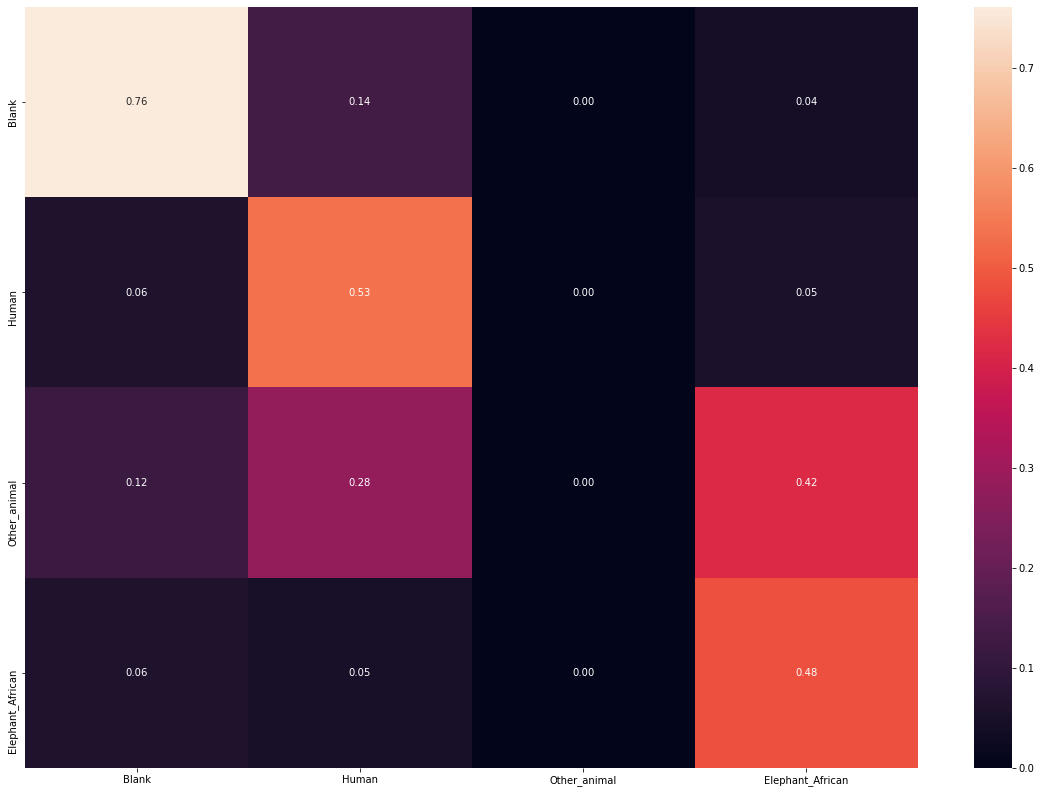

In [29]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [ ]:
correctly_classified = {}
total = {}
for idx, i in enumerate(true_categories):
    if i == predicted_categories[idx].numpy():
        if CLASS_NAMES[i] in correctly_classified.keys():
            correctly_classified[CLASS_NAMES[i]] += 1
        else:
            correctly_classified[CLASS_NAMES[i]] = 1
    
    if CLASS_NAMES[i] in total.keys():
        total[CLASS_NAMES[i]] += 1
    else:
        total[CLASS_NAMES[i]] = 1
            
print("correct:", correctly_classified)
print("total:  ", total)

In [291]:
plt.ion()
index = 0
for idx, i in enumerate(test_ds_myan):   
    for j in i[0]:
#         if y_pred[index][y_pred[index].argmax()] > 0.90:
        if predicted_categories[index].numpy() != true_categories[index]:
            plt.figure(figsize = (16,16))
            plt.imshow(j)
            plt.show()
            print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
            print("True: "+ str(CLASS_NAMES[true_categories[index]]))
        index+=1

KeyboardInterrupt: 

# Results

In [28]:
test_path = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren_4classes.csv"
test_ds = load_dataset(test_path, BATCH_SIZE, training=False)

In [29]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(test_acc)

341/341 [==============================] - 1269s 4s/step - loss: 1.0303 - accuracy: 0.6561
0.6560579538345337


In [35]:
print(test_acc)

0.8812270164489746


In [21]:
PREDICTIONS = len(test_data)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

340it [01:00,  5.61it/s]

43520


In [22]:
y_pred = model.predict(test_ds, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test

In [23]:
new_labels = CLASS_NAMES.copy()
report = classification_report(predicted_categories, true_categories, output_dict=True)
df = pd.DataFrame(report).transpose()
if new_labels[len(new_labels) -1] != "-":
    new_labels = np.append(new_labels, ["-", "-", "-"])
df = df.round(decimals=2)
df['label'] = new_labels
df["precision"].iloc[len(new_labels) -3] = "-"
df["recall"].iloc[len(new_labels) -3] = "-"
df["support"].iloc[len(new_labels) -3] = df["support"].iloc[len(new_labels) -2]
df

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,precision,recall,f1-score,support,label
0,0.94,0.92,0.93,29186.0,Other_animal
1,0.84,0.86,0.85,4852.0,Human
2,0.76,0.73,0.75,5166.0,Elephant_African
3,0.73,0.84,0.78,4316.0,Blank
accuracy,-,-,0.88,43520.0,-
macro avg,0.82,0.84,0.83,43520.0,-
weighted avg,0.88,0.88,0.88,43520.0,-


In [41]:
y_pred[0]

array([0.19569719, 0.78062403, 0.01439491, 0.00928379], dtype=float32)

In [32]:
mean_aggregated_cross_entropy_loss = {}

for idx, pred in enumerate(y_pred):
    loss = -math.log(pred[true_categories[idx]])
    if CLASS_NAMES[true_categories[idx]] in mean_aggregated_cross_entropy_loss:
        mean_aggregated_cross_entropy_loss[CLASS_NAMES[true_categories[idx]]].append(loss)
    else:
        mean_aggregated_cross_entropy_loss[CLASS_NAMES[true_categories[idx]]] = [loss]

for keys, values in mean_aggregated_cross_entropy_loss.items():
    mean = sum(values)/ len(values)
    mean_aggregated_cross_entropy_loss[keys] = round(mean, 2)
    
mean_aggregated_cross_entropy_loss

{'Blank': 1.1, 'Human': 0.48, 'Elephant_African': 0.75, 'Other_animal': 0.21}

In [24]:
# y_pred = model.predict(test_ds, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
cm = confusion_matrix(predicted_categories, true_categories, normalize="true")
df_cm = pd.DataFrame(cm, index = [i for i in CLASS_NAMES],
                  columns = [i for i in CLASS_NAMES])

<AxesSubplot:>

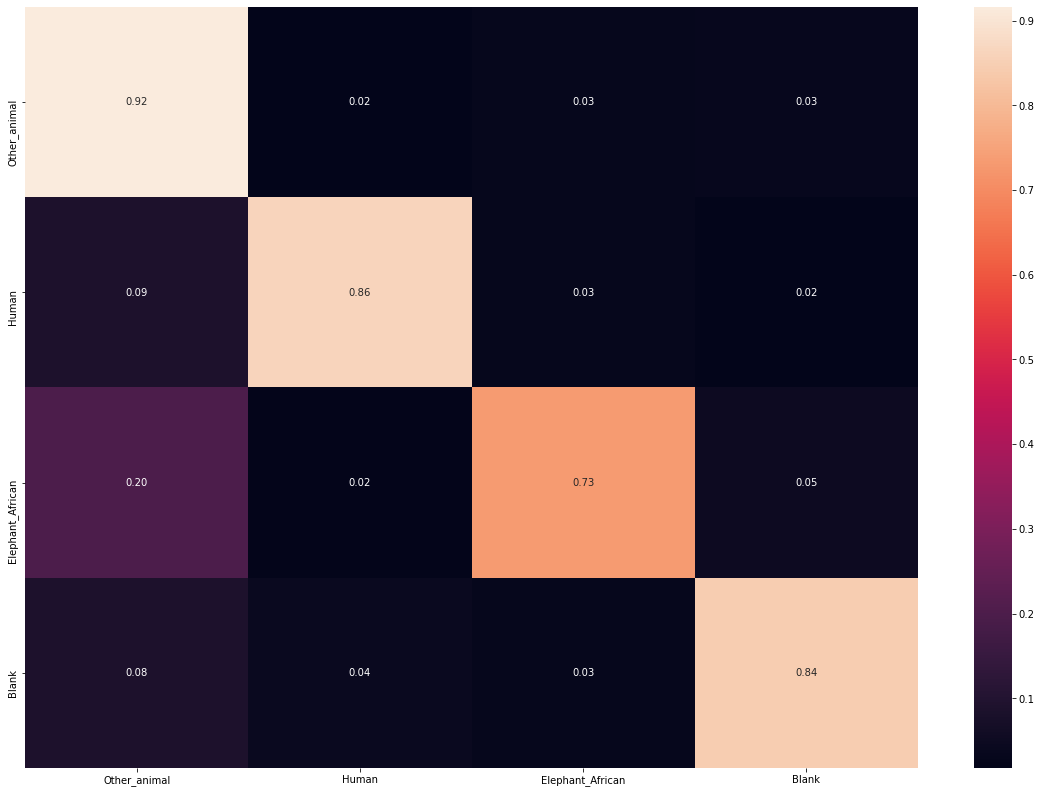

In [25]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [42]:
CLASS_NAMES

array(['Rat_Giant', 'Squirrel', 'Duiker_Red', 'Rodent', 'Human',
       'Guineafowl_Black', 'Monkey', 'Duiker_Blue',
       'Duiker_Yellow_Backed', 'Elephant_African', 'Rail_Nkulengu',
       'Bird', 'Blank', 'Mandrillus', 'Chevrotain_Water',
       'Porcupine_Brush_Tailed', 'Leopard_African', 'Mongoose',
       'Hog_Red_River', 'Chimpanzee', 'Guineafowl_Crested',
       'Buffalo_African', 'Genet', 'Mongoose_Black_Footed',
       'Civet_African_Palm', 'Pangolin', 'Gorilla', 'Cat_Golden'],
      dtype=object)

In [43]:
prediction_dict = {'Rat_Giant':[], 'Squirrel':[], 'Duiker_Red':[], 'Rodent':[], 'Human':[],
       'Guineafowl_Black':[], 'Monkey':[], 'Duiker_Blue':[],
       'Duiker_Yellow_Backed':[], 'Elephant_African':[], 'Rail_Nkulengu':[],
       'Bird':[], 'Blank':[], 'Mandrillus':[], 'Chevrotain_Water':[],
       'Porcupine_Brush_Tailed':[], 'Leopard_African':[], 'Mongoose':[],
       'Hog_Red_River':[], 'Chimpanzee':[], 'Guineafowl_Crested':[],
       'Buffalo_African':[], 'Genet':[], 'Mongoose_Black_Footed':[],
       'Civet_African_Palm':[], 'Pangolin':[], 'Gorilla':[], 'Cat_Golden':[]}
index = 0
counter = 0
for idx, i in enumerate(tqdm(test_ds)):
    if counter < PREDICTIONS:
        counter+=1
        for j in i[0]:
            if predicted_categories[index].numpy() != true_categories[index]:
                prediction_dict[CLASS_NAMES[true_categories[index]]].append(predicted_categories[index].numpy())
            index+=1

341it [01:03,  5.34it/s]


In [44]:
for true_classes in prediction_dict.keys():
    classes = []
    for i in range(len(CLASS_NAMES)):
        counter = 0
        for j in prediction_dict[true_classes]:
            if j == i:
                counter +=1
        classes.append(counter)
    prediction_dict[true_classes] = classes

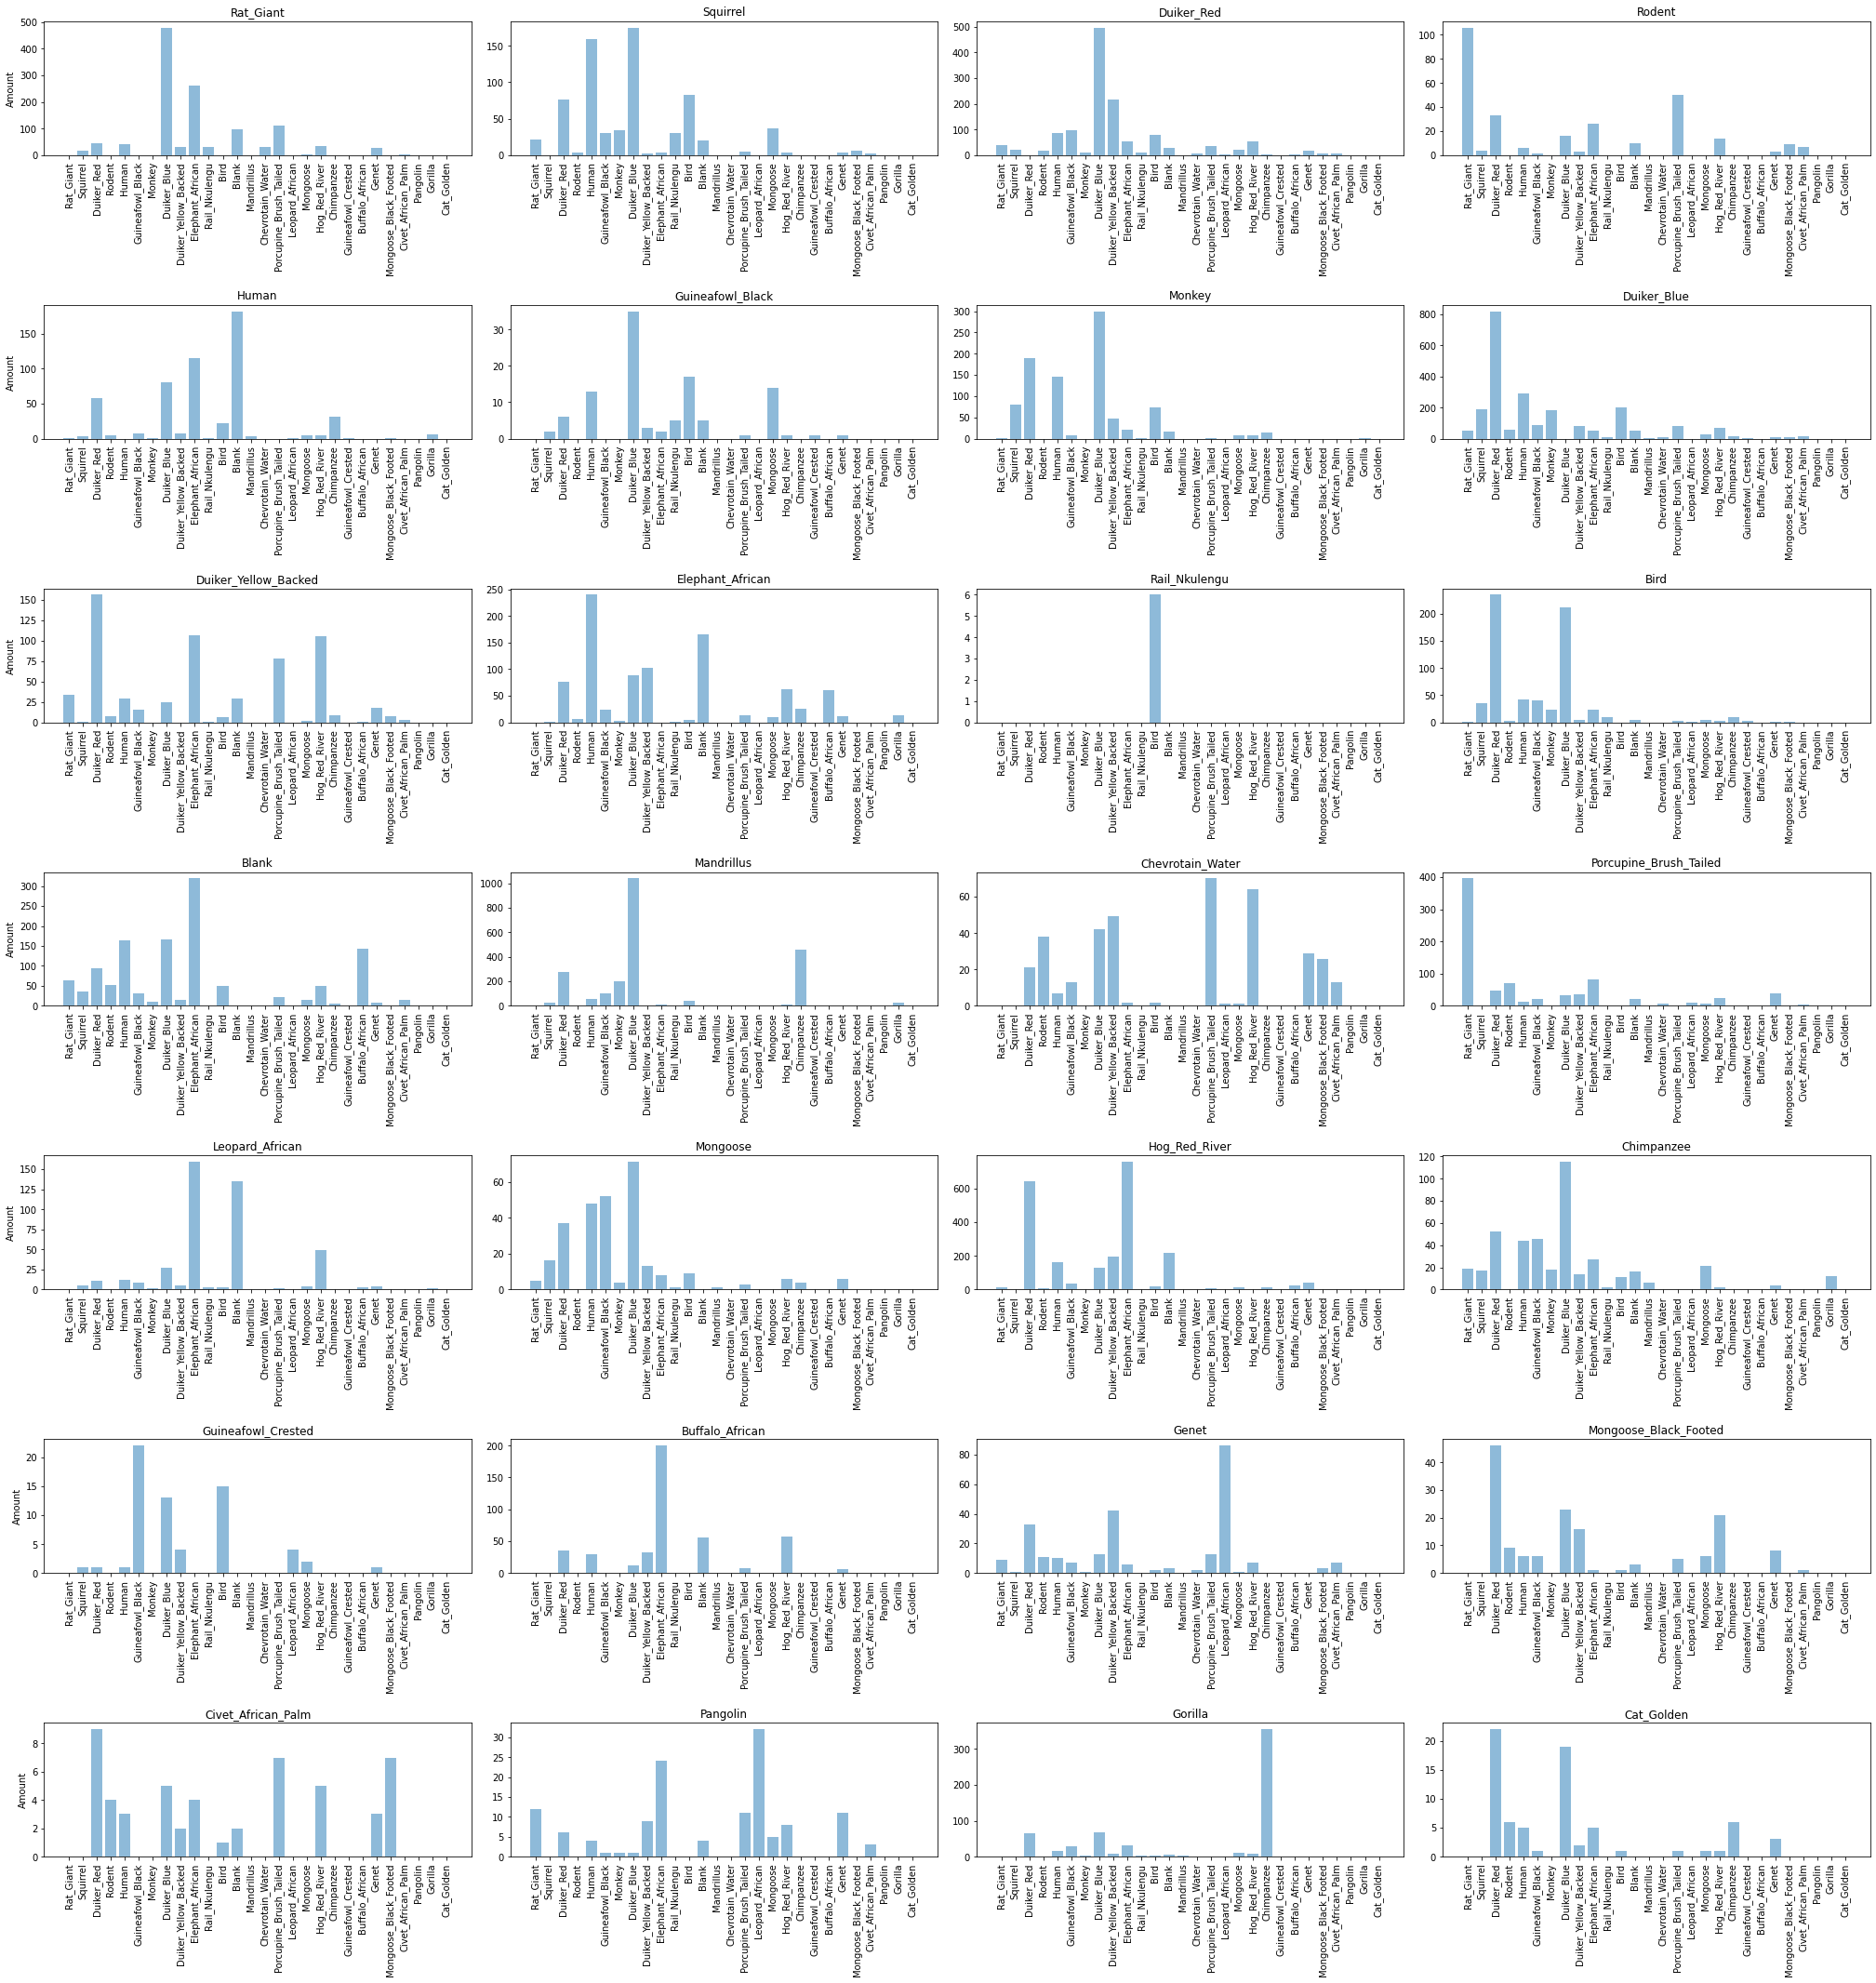

In [45]:
y_pos = np.arange(len(CLASS_NAMES))
f, axarr = plt.subplots(7,4, figsize=(28,28))
f.tight_layout(h_pad=14)

col = 0
row = 0
for name in prediction_dict.keys():
    if col < 4:
        axarr[row][col].bar(y_pos, prediction_dict[name], align='center', alpha=0.5, tick_label=CLASS_NAMES)
        axarr[row][col].set_title(name)
        axarr[row][col].set_xticklabels(CLASS_NAMES, rotation=90)
        axarr[row][0].set_ylabel('Amount')
        col += 1
    else:
        row += 1
        col = 0
        axarr[row][col].bar(y_pos, prediction_dict[name], align='center', alpha=0.5, tick_label=CLASS_NAMES)
        axarr[row][col].set_title(name)
        axarr[row][col].set_xticklabels(CLASS_NAMES, rotation=90)
        axarr[row][0].set_ylabel('Amount')
        col += 1
        
        

In [46]:
train_data.groupby(0).nunique()

,1
0,
Bird,4742
Blank,23956
Buffalo_African,4826
Cat_Golden,276
Chevrotain_Water,3461
Chimpanzee,4133
Civet_African_Palm,716
Duiker_Blue,23997
Duiker_Red,23945


In [26]:
# plt.ion()
# index = 0
# for idx, i in enumerate(test_ds):   
#     for j in i[0]:
# #         if y_pred[index][y_pred[index].argmax()] > 0.90:
#         if predicted_categories[index].numpy() != true_categories[index]:
#             plt.figure(figsize = (16,16))
#             plt.imshow(j)
#             plt.show()
#             print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
#             print("True: "+ str(CLASS_NAMES[true_categories[index]]))
#         index+=1

# Saves

FileNotFoundError: [Errno 2] No such file or directory: 'gs://dataset-gabon/train_val_test_csv_Siebren/Confusion_matrix/MobileNetV2_5epoch_0.719acc.png'

# Results

MobileNetV2 | 3 epochs training | test acc 0.713 | batch size 128 |

In [ ]:
MobileNetV2 | 5 epochs training | test acc 0.719 | batch size 128 |

In [ ]:
Xception    | 3 epochs training | val acc 0.754  | batch size 128 |

In [ ]:
Xception    | 5 epochs training | val acc 0.761  | batch size 128 |

In [ ]:
Xception    | 5+1 epochs training | val acc 0.765  | batch size 128 |